# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [2]:
# loading the data:
customers = pd.read_csv('../Wholesale customers data.csv')

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [3]:
# Your code here:
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


1) FRESH: annual spending (m.u.) on fresh products (Continuous);
2) MILK: annual spending (m.u.) on milk products (Continuous);
3) GROCERY: annual spending (m.u.)on grocery products (Continuous);
4) FROZEN: annual spending (m.u.)on frozen products (Continuous)
5) DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
6) DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous);
7) CHANNEL: customersâ€™ Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal)
8) REGION: customersâ€™ Region â€“ Lisnon, Oporto or Other (Nominal)


In [4]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
Channel             440 non-null int64
Region              440 non-null int64
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicassen          440 non-null int64
dtypes: int64(8)
memory usage: 27.6 KB


All of the datas are numericals and no nulls so nothing to remove

In [5]:
correlations = customers.corr()
correlations

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,1.000000,0.062028,-0.169172,0.460720,0.608792,-0.202046,0.636026,0.056011
Region,0.062028,1.000000,0.055287,0.032288,0.007696,-0.021044,-0.001483,0.045212
Fresh,-0.169172,0.055287,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.460720,0.032288,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,0.608792,0.007696,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,-0.202046,-0.021044,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,0.636026,-0.001483,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicassen,0.056011,0.045212,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


CORRELATIONS: Channel with Grocery and Detergents_Paper and Milk with Grocery and Detergents_Paper

In [7]:
stats = customers.describe().T
stats['IQR'] = stats['75%'] - stats['25%']

outliers = pd.DataFrame(columns=customers.columns)

for col in stats.index:
    iqr = stats.at[col,'IQR']
    cutoff = iqr * 1.5
    lower = stats.at[col,'25%'] - cutoff
    upper = stats.at[col,'75%'] + cutoff
    results = customers[(customers[col] < lower) | 
                   (customers[col] > upper)].copy()
    results['Outlier'] = col
    outliers = outliers.append(results)
    
outliers['Outlier'].value_counts()

Frozen              43
Detergents_Paper    30
Milk                28
Delicassen          27
Grocery             24
Fresh               20
Name: Outlier, dtype: int64

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [9]:
# Your code here
Q1 = customers.quantile(0.25)
Q3 = customers.quantile(0.75)
IQR = Q3 - Q1
customers_outliers = customers[((customers< (Q1 - 1.5 * IQR)) |(customers > (Q3 + 1.5 * IQR))).any(axis=1)].index
customers.drop(customers_outliers,inplace=True)
customers.shape

(332, 8)

In [10]:
len(customers)

332

In [ ]:
# Your comment here
# Droping the outliers is the best option for not having fake conclusions

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [11]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Your code here:
scaler = StandardScaler()
customers_scale = scaler.fit_transform(customers)

# Challenge 3 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [12]:
# Your code here:
from sklearn.cluster import KMeans
kmeans = KMeans().fit(customers_scale)
customers['labels'] = kmeans.labels_

Count the values in `labels`.

In [13]:
# Your code here:
customers['labels'].value_counts(normalize=False)

0    104
3     46
1     43
4     34
5     32
7     31
6     23
2     19
Name: labels, dtype: int64

# Challenge 4 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [15]:
# Your code here
from sklearn.cluster import DBSCAN
model_dbscan = DBSCAN(eps=0.5).fit(customers_scale)
customers['labels_DBSCAN'] = model_dbscan.labels_

Count the values in `labels_DBSCAN`.

In [16]:
# Your code here
customers['labels_DBSCAN'].value_counts()

-1    308
 0     24
Name: labels_DBSCAN, dtype: int64

# Challenge 5 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

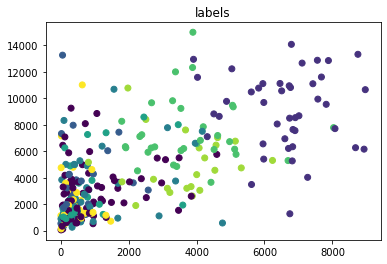

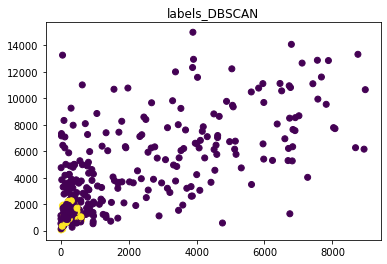

In [18]:
# Your code here:
plt.scatter(customers['Detergents_Paper'], customers['Milk'], c=customers['labels']);
plt.title("labels")
plt.show()


plt.scatter(customers['Detergents_Paper'], customers['Milk'], c=customers['labels_DBSCAN']);
plt.title("labels_DBSCAN")
plt.show()

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

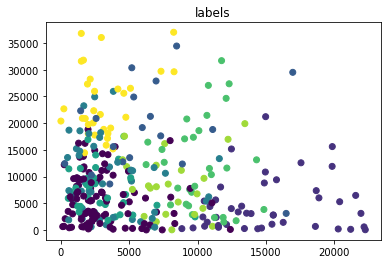

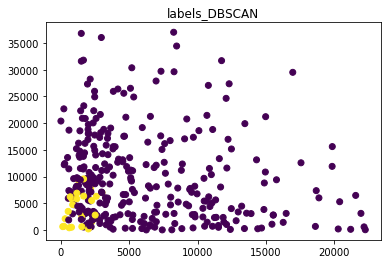

In [19]:
# Your code here:
plt.scatter(customers['Grocery'], customers['Fresh'], c=customers['labels']);
plt.title("labels")
plt.show()


plt.scatter(customers['Grocery'], customers['Fresh'], c=customers['labels_DBSCAN']);
plt.title("labels_DBSCAN")
plt.show()

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

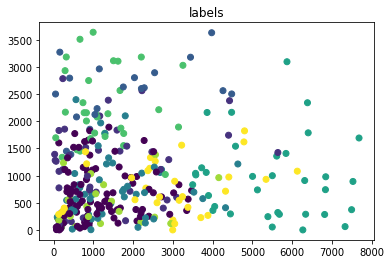

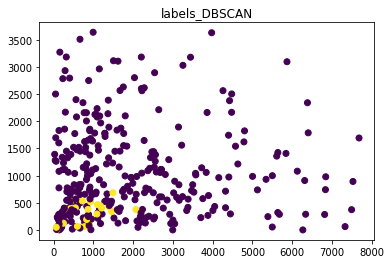

In [20]:
# Your code here:
plt.scatter(customers['Frozen'], customers['Delicassen'], c=customers['labels']);
plt.title("labels")
plt.show()


plt.scatter(customers['Frozen'], customers['Delicassen'], c=customers['labels_DBSCAN']);
plt.title("labels_DBSCAN")
plt.show()

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [21]:
# Your code here:
customers.groupby(['labels', 'labels_DBSCAN']).mean()

Channel    Region         Fresh         Milk  \
labels labels_DBSCAN                                                  
0      -1             1.000000  2.937500   6351.925000  2766.225000   
        0             1.000000  3.000000   4344.625000  1124.333333   
1      -1             1.930233  2.581395   4549.209302  9060.558140   
2      -1             1.000000  2.578947  18734.105263  4340.315789   
3      -1             1.000000  1.152174   9646.565217  2790.500000   
4      -1             1.029412  2.411765   6883.558824  2720.000000   
5      -1             1.968750  2.843750  12354.812500  7405.375000   
6      -1             2.000000  2.739130   8503.521739  4852.173913   
7      -1             1.000000  2.806452  23775.129032  2359.774194   

                           Grocery       Frozen  Detergents_Paper   Delicassen  
labels labels_DBSCAN                                                            
0      -1              3511.200000  1200.075000        853.400000   745.962500  
        0              1411.875000   846.875000        230.666667   329.125000  
1      -1             15092.348837  1334.860465       6598.069767  1095.860465  
2      -1              6459.157895  1741.473684        686.789474  2530.421053  
3      -1              3526.934783  1576.913043        881.804348   772.239130  
4      -1              3011.117647  5439.529412        695.470588   957.882353  
5      -1              9922.562500  1256.843750       3785.156250  2232.312500  
6      -1              8054.304348  1203.086957       3515.956522   473.913043  
7      -1              3123.870968  2785.225806        438.870968   784.225806

Which algorithm appears to perform better?

In [ ]:
# Your observations here: DBSCAN performs better.


# Bonus Challenge 2 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [ ]:
# Your code here

In [ ]:
# Your comment here

# Bonus Challenge 3 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [ ]:
# Your code here

In [ ]:
# Your comment here